### Returns을 찍어보자

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from scipy.stats import stats
from tqdm import tqdm

In [ ]:
mktcap = pd.read_pickle("ryu_mktcap.pickle")
price  = pd.read_pickle("ryu_price.pickle")

In [106]:
class CrossSection:
    def __init__(self, price_df:pd.DataFrame, mktcap_df:pd.DataFrame, freq:str):
        '''freq(str) : [daily, 3days, weekly]'''
        map_dict = {"daily" :[1, None],
                    "3days" :[3, "3D"],
                    "weekly":[7, "W"] }
        self.__freq_str = freq
        self.__freq_lst = map_dict[freq]
        
        self.__price_df = price_df.copy()
        self.__mktcap = mktcap_df.copy()
        self.__mktcap_df = self.__preprocess_mktcap()
        self.__rtn_df = self.__preprocess_price()
    
    def __preprocess_price(self):
        price = self.__price_df
        pct = price.pct_change(self.__freq_lst[0], fill_method=None)
        
        if self.__freq_str == "daily":
            pass
        else:
            pct = pct.resample(self.__freq_lst[1]).first()
        sign = np.sign(price.loc[pct.index[:-1]])
        rtn = pct * sign        
        return rtn
    
    def __preprocess_mktcap(self):
        mktcap = self.__mktcap
        if self.__freq_str == "daily":
            pass
        else:
            mktcap = mktcap.resample(self.__freq_lst[1]).first()
        return mktcap
    
    def calculate_cagr(self, return_df):
        scaler = self.mapping_scaler[self.__freq_str]
        holding_year = (len(return_df) / scaler)
        cum = (return_df+1).cumprod()
        cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
        return cagr
    
    def mkt_index(self):
        pct = self.__rtn_df
        mktcap = self.__mktcap_df
        
        weight = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
        return (pct * weight.shift(1)).sum(1).iloc[:-1]
        
    def q_momentum(self, q:str, num_of_coin:int, return_num = False):
        '''Q(str) : "3" 3분위, "5" 5분위 
           num_of_coin : 그룹당 최소 코인 수 
           return_num : 그룹별 코인수를 리턴할지(default : False)'''
        mktcap = self.__mktcap_df
        rtn = self.__rtn_df
        self.__return_num = return_num
        q_map = {"5":[0.2, 0.4, 0.6, 0.8],
                 "3":[1/3, 2/3]}
        thresh = rtn.apply(lambda x: np.nanquantile(x,q_map[q]),
                           axis=1)
        
        sum_dict = {}
        weight_dict = {}
        for i in tqdm(range(0, len(q_map[q]) + 1)):  
                      
            if i == 0: # 첫번째 분위수 계산
                thr = thresh.apply(lambda x: x[i])
                filter_df = rtn.apply(lambda x: x <= thr, axis=0) \
                           .replace(True, 1).replace(False, np.nan)
            elif i == (len(q_map[q])): # 마지막 분위수 계산
                thr = thresh.apply(lambda x: x[i-1])
                filter_df = rtn.apply(lambda x: x > thr, axis=0) \
                          .replace(True, 1).replace(False, np.nan)
            else: # 가운데인 경우
                thr = thresh.apply(lambda x: x[i-1])
                thr2 = thresh.apply(lambda x: x[i])
                filter_df = rtn.apply(lambda x: (thr < x) & (x <= thr2), axis=0) \
                            .replace(True, 1).replace(False, np.nan)       
            
            sum_dict[str(i)] = filter_df.sum(1)
            weight = (filter_df * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
            weight_dict[str(i)] = weight     
                   
        num_coin = pd.concat(sum_dict, axis=1)        
        slice = num_coin[num_coin >= num_of_coin].dropna(axis=0)
        self.__start_date = slice.index[0]
        print("{}에서부터 수익률을 계산".format(self.__start_date))
        
        return_dict = {}
        for i in range(len(weight_dict.keys())):
            group_rtn = ((rtn * weight_dict[str(i)].shift(1)).loc[self.__start_date:].iloc[:-1].sum(1))
            return_dict["Q" + str(i+1)] = group_rtn
            
        if return_num:
            return_dict["count"] = num_coin.loc[self.__start_date:].iloc[:-1]
            
        return return_dict
    
    def run_alpha_regression(self, return_dict, constant=True):
        '''add_constant : True(Default)/ False'''
        
        for key, strategy_df in return_dict.items():
            if str(key) =="count":
                continue
            tmp_mktrtn = self.mkt_index().loc[self.__start_date:]

            if constant:
                model = OLS(strategy_df, add_constant(tmp_mktrtn))
            else:
                model = OLS(strategy_df, tmp_mktrtn)
            result = model.fit()

            print(f"{key} Regression Result")
            print(result.summary2())
            
    def print_statistics(self, return_dict, with_mkt:False):
        self.mapping_scaler = {"daily":365,
                          "3days":122,
                          "weekly":52}
        scaler = self.mapping_scaler[self.__freq_str]
        df_key = list(return_dict.keys())
        
        if self.__return_num:
            df_key = list(return_dict.keys())[:-1]
            
        mean = [df.mean().round(6) for key, df in return_dict.items() if key != "count"]          
        std = [df.std() for key, df in return_dict.items() if key != "count"]
        cagr =[self.calculate_cagr(df) for key, df in return_dict.items() if key != "count"]          
        return_df = pd.DataFrame([cagr,mean,std], 
                                 index=["CAGR", "Mean","STD"], 
                                 columns=df_key)
        if with_mkt:
            mkt_index = self.mkt_index().loc[self.__start_date:]
            mkt = pd.DataFrame([self.calculate_cagr(mkt_index), mkt_index.mean(), mkt_index.std()],
                               index=["CAGR", "Mean","STD"], 
                               columns=["MKT"])
            return_df = pd.concat([return_df, mkt], axis=1)
        return_df.loc["Shape",:] = (return_df.loc["Mean",:]*scaler)/ (return_df.loc["STD",:]*np.sqrt(scaler))
        return return_df
        
    def draw_return_result(self, return_dict:dict, with_mkt=False):
        '''rtn_result : dict
           with_mkt   : bool -> 마켓인덱스를 함께 그릴지 표시'''
        if with_mkt:
            mktrtn = self.mkt_index().loc[self.__start_date:]

        for key, df in return_dict.items():
            if str(key) == "count":
                continue
            fig, axes = plt.subplots(3,1, sharex=True, figsize=(24,24), 
                                     gridspec_kw={'height_ratios': [4, 1, 1]})
            cum_df = (df+1).cumprod()
            cum_df.plot(ax=axes[0])
                
            axes[0].set_title("{} Cross-Sectional Momentum Cummulative {} returns weighted by marketcap".format(key,self.__freq_str))
            axes[0].grid()
            axes[0].legend(["Startegy","MKT"])

            peak = cum_df.cummax()
            drawdown = (cum_df-peak)/peak
            drawdown.plot(ax=axes[1])
            axes[1].set_title("Draw Down")
            axes[1].grid()

            df.plot(ax=axes[2])
            axes[2].set_title("{} Returns".format(self.__freq_str))
            axes[2].grid()
            
            if with_mkt:
                mktcum = (mktrtn+1).cumprod()
                mktcum.plot(ax=axes[0])
                axes[0].grid()
                axes[0].legend(["Startegy","MKT"])
                peak = mktcum.cummax()
                drawdown = (mktcum-peak)/peak
                drawdown.plot(ax=axes[1])
                axes[1].grid();               

In [ ]:
weekly = CrossSection(price, mktcap, freq="weekly")
q5_weekly = weekly.q_momentum("5", 20, True)
#three_weekly = weekly.q_momentum("3", 20, True)

In [122]:
daily = CrossSection(price, mktcap, freq="daily")
q5_daily = daily.q_momentum("5", 45, True)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
 40%|████      | 2/5 [00:36<00:54, 18.19s/it]

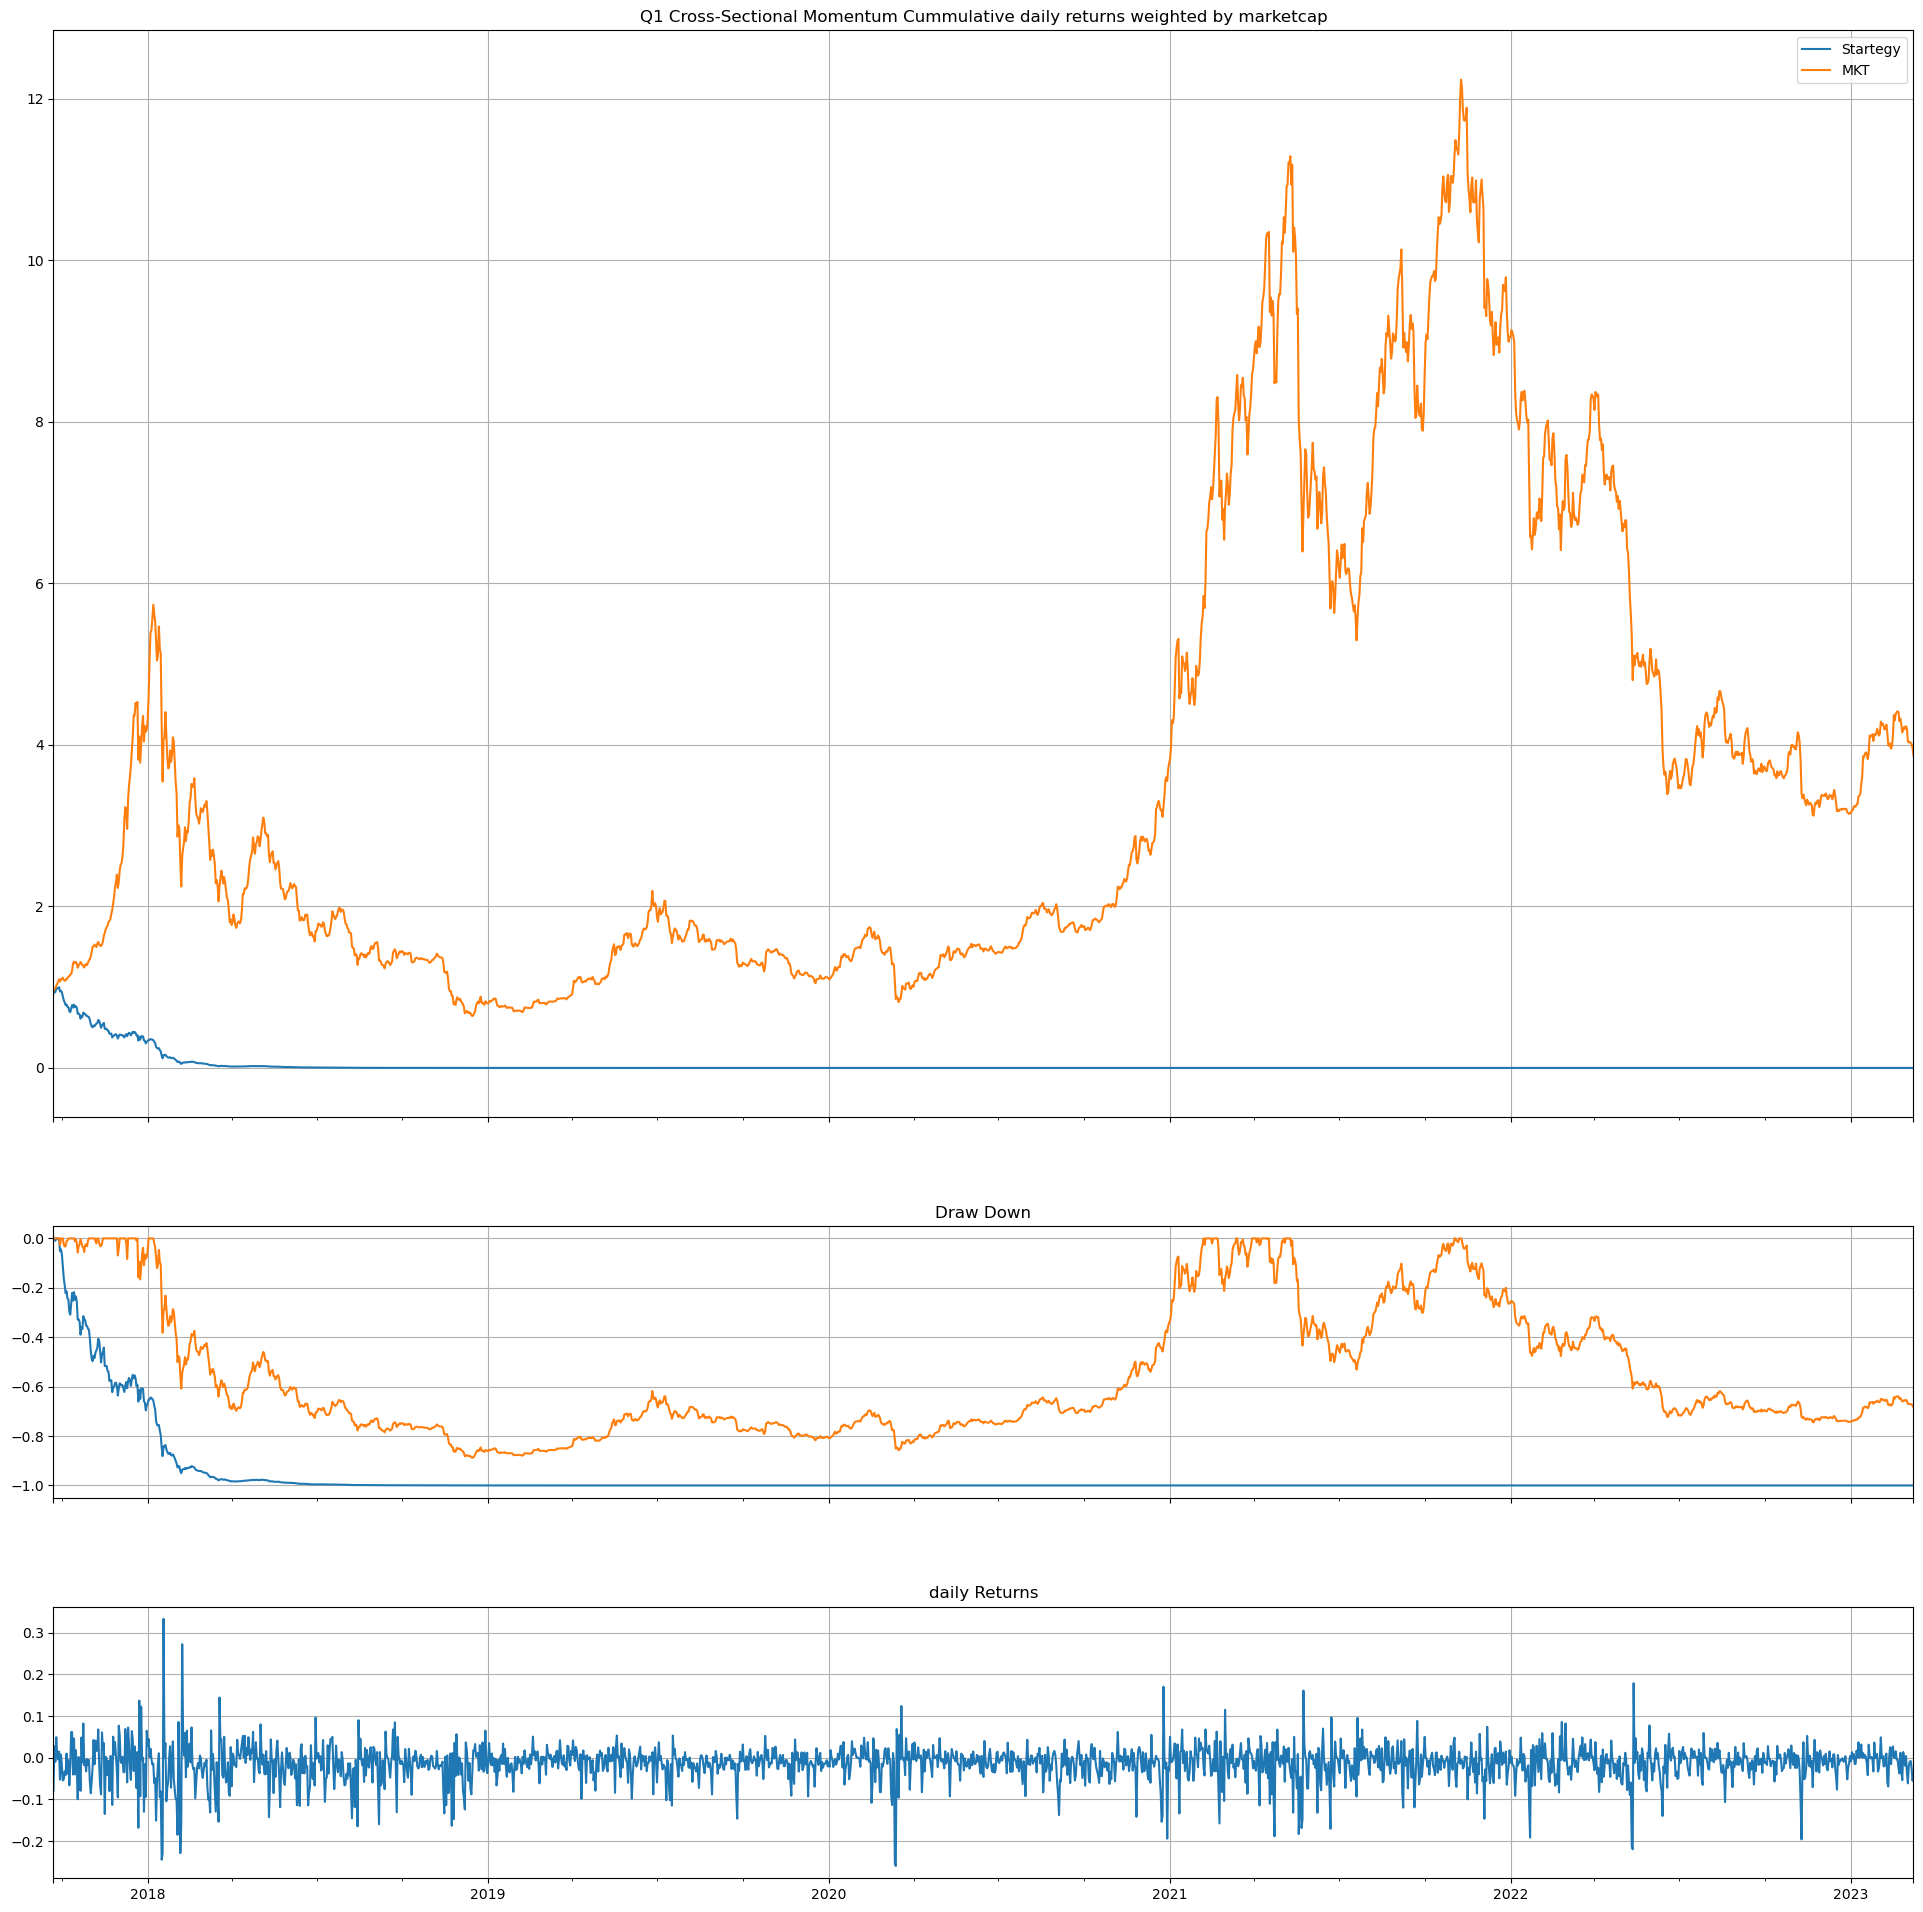

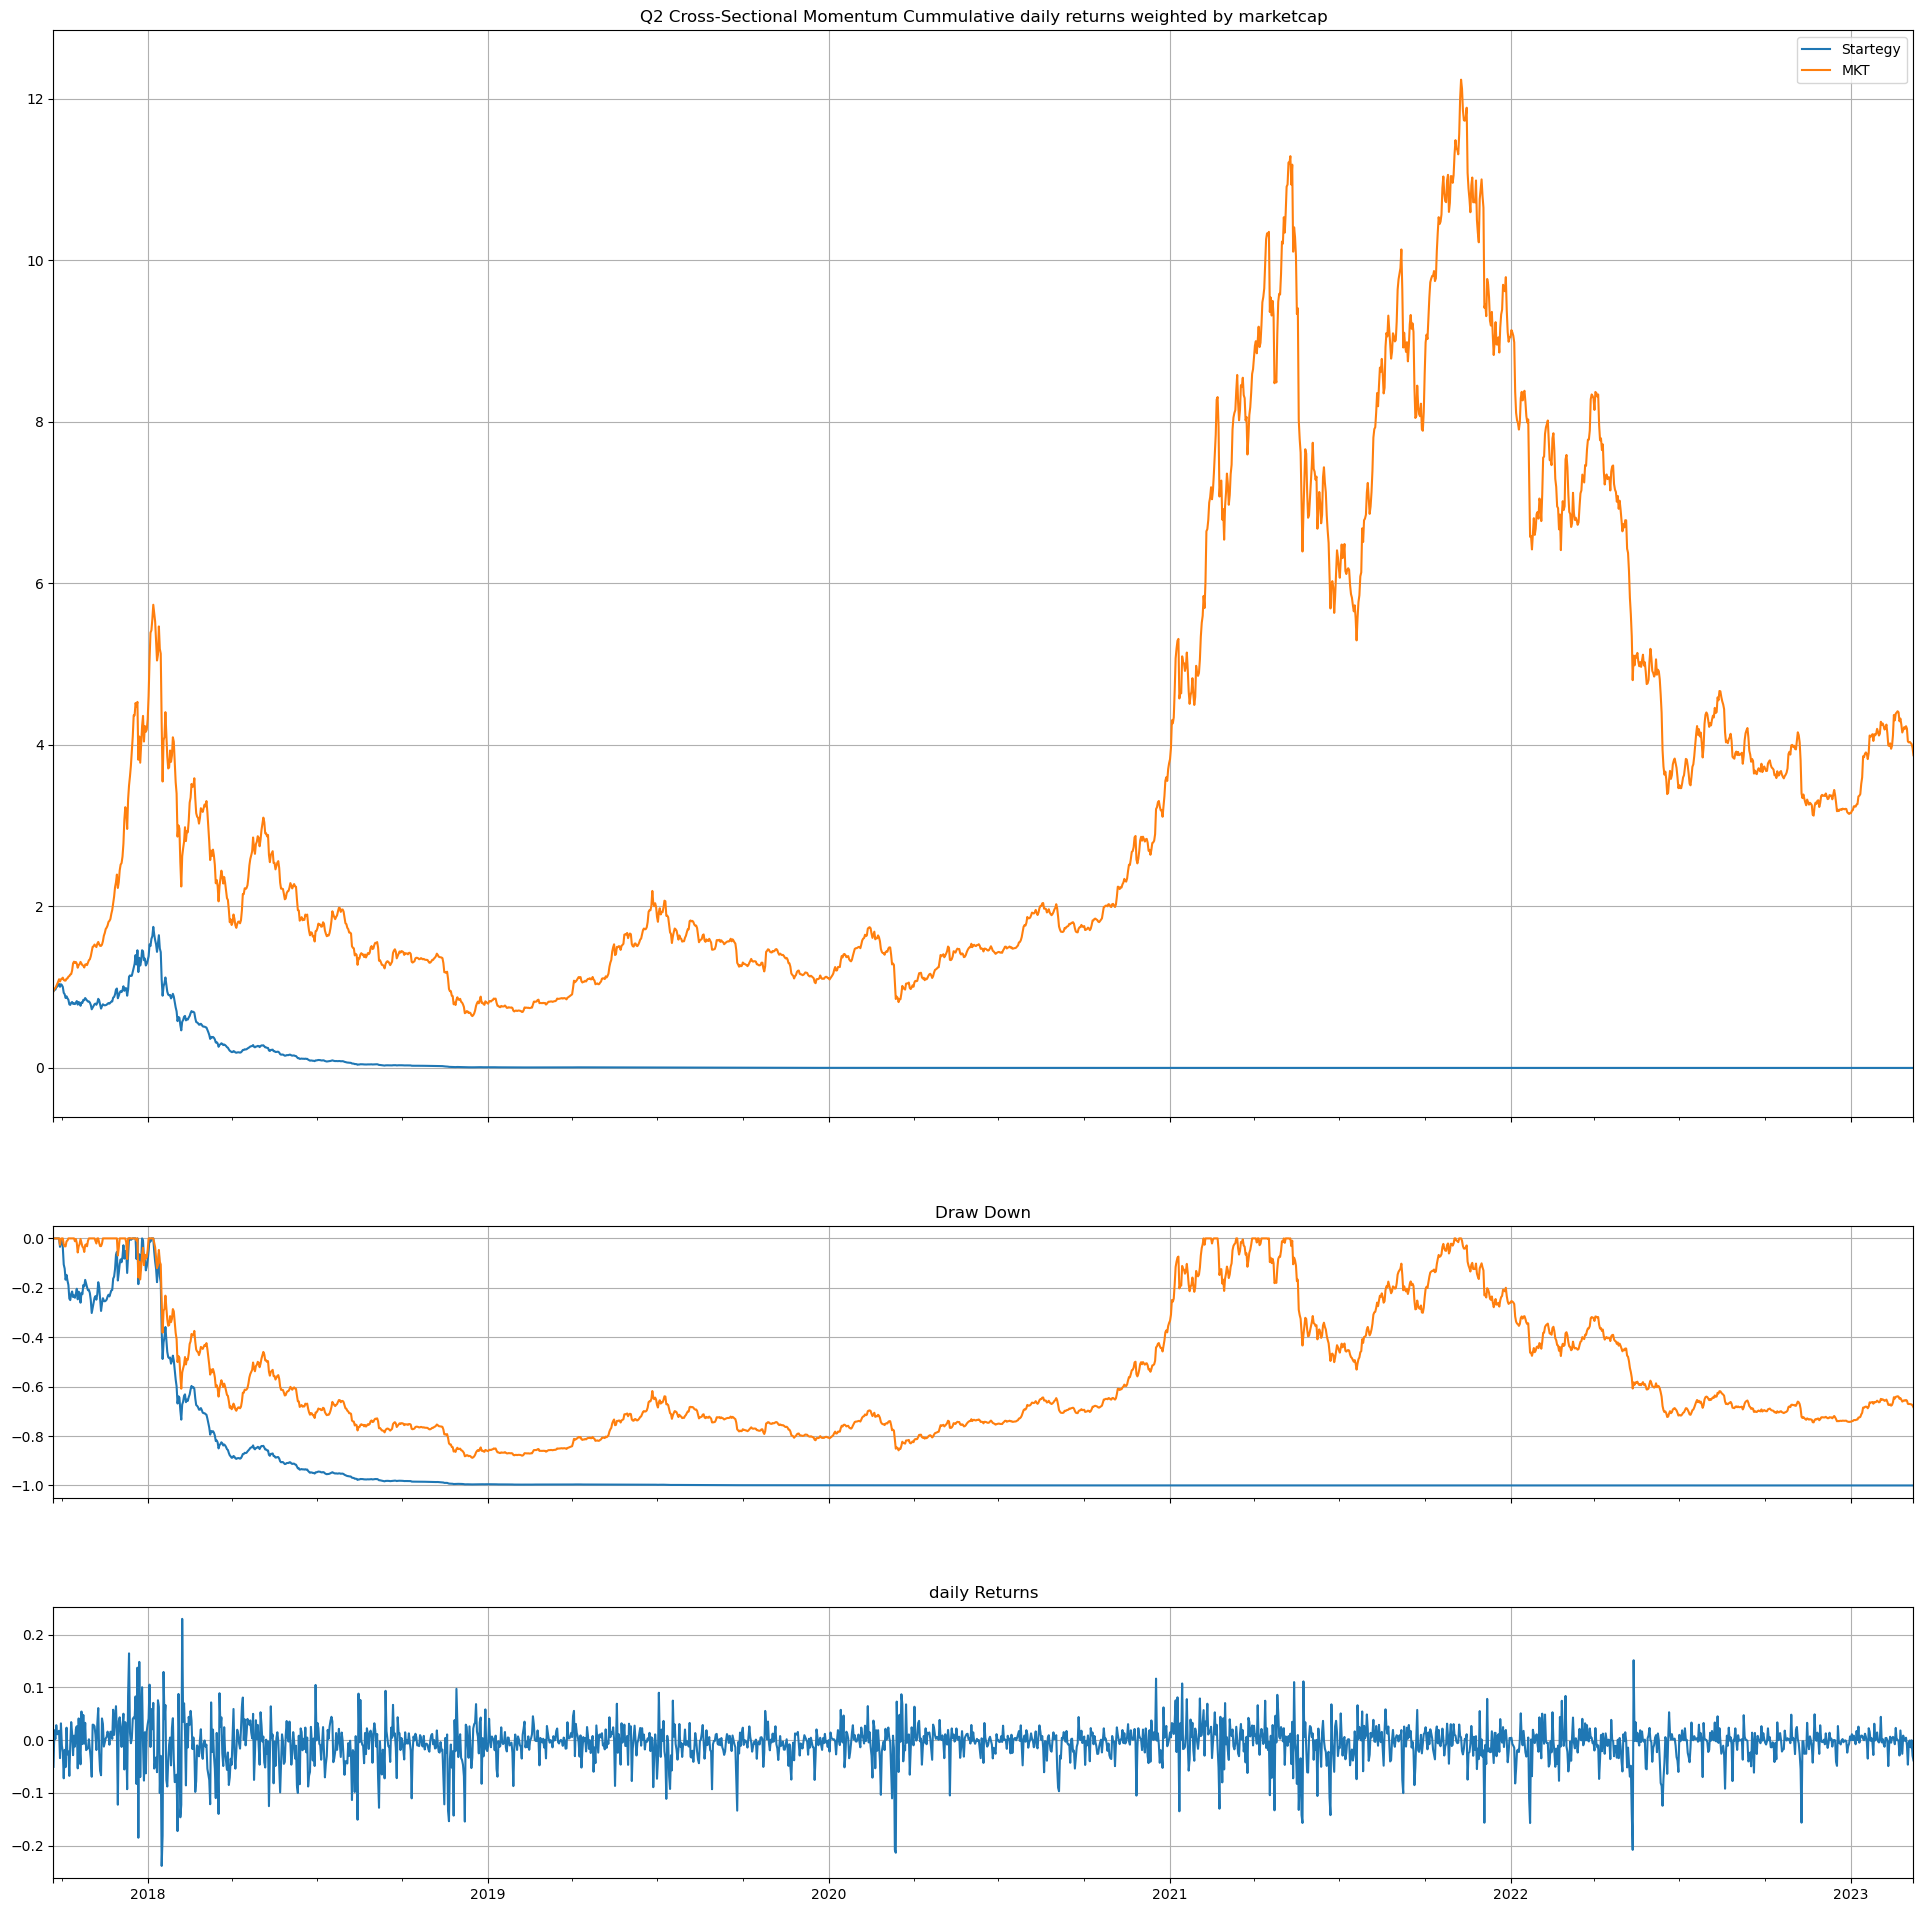

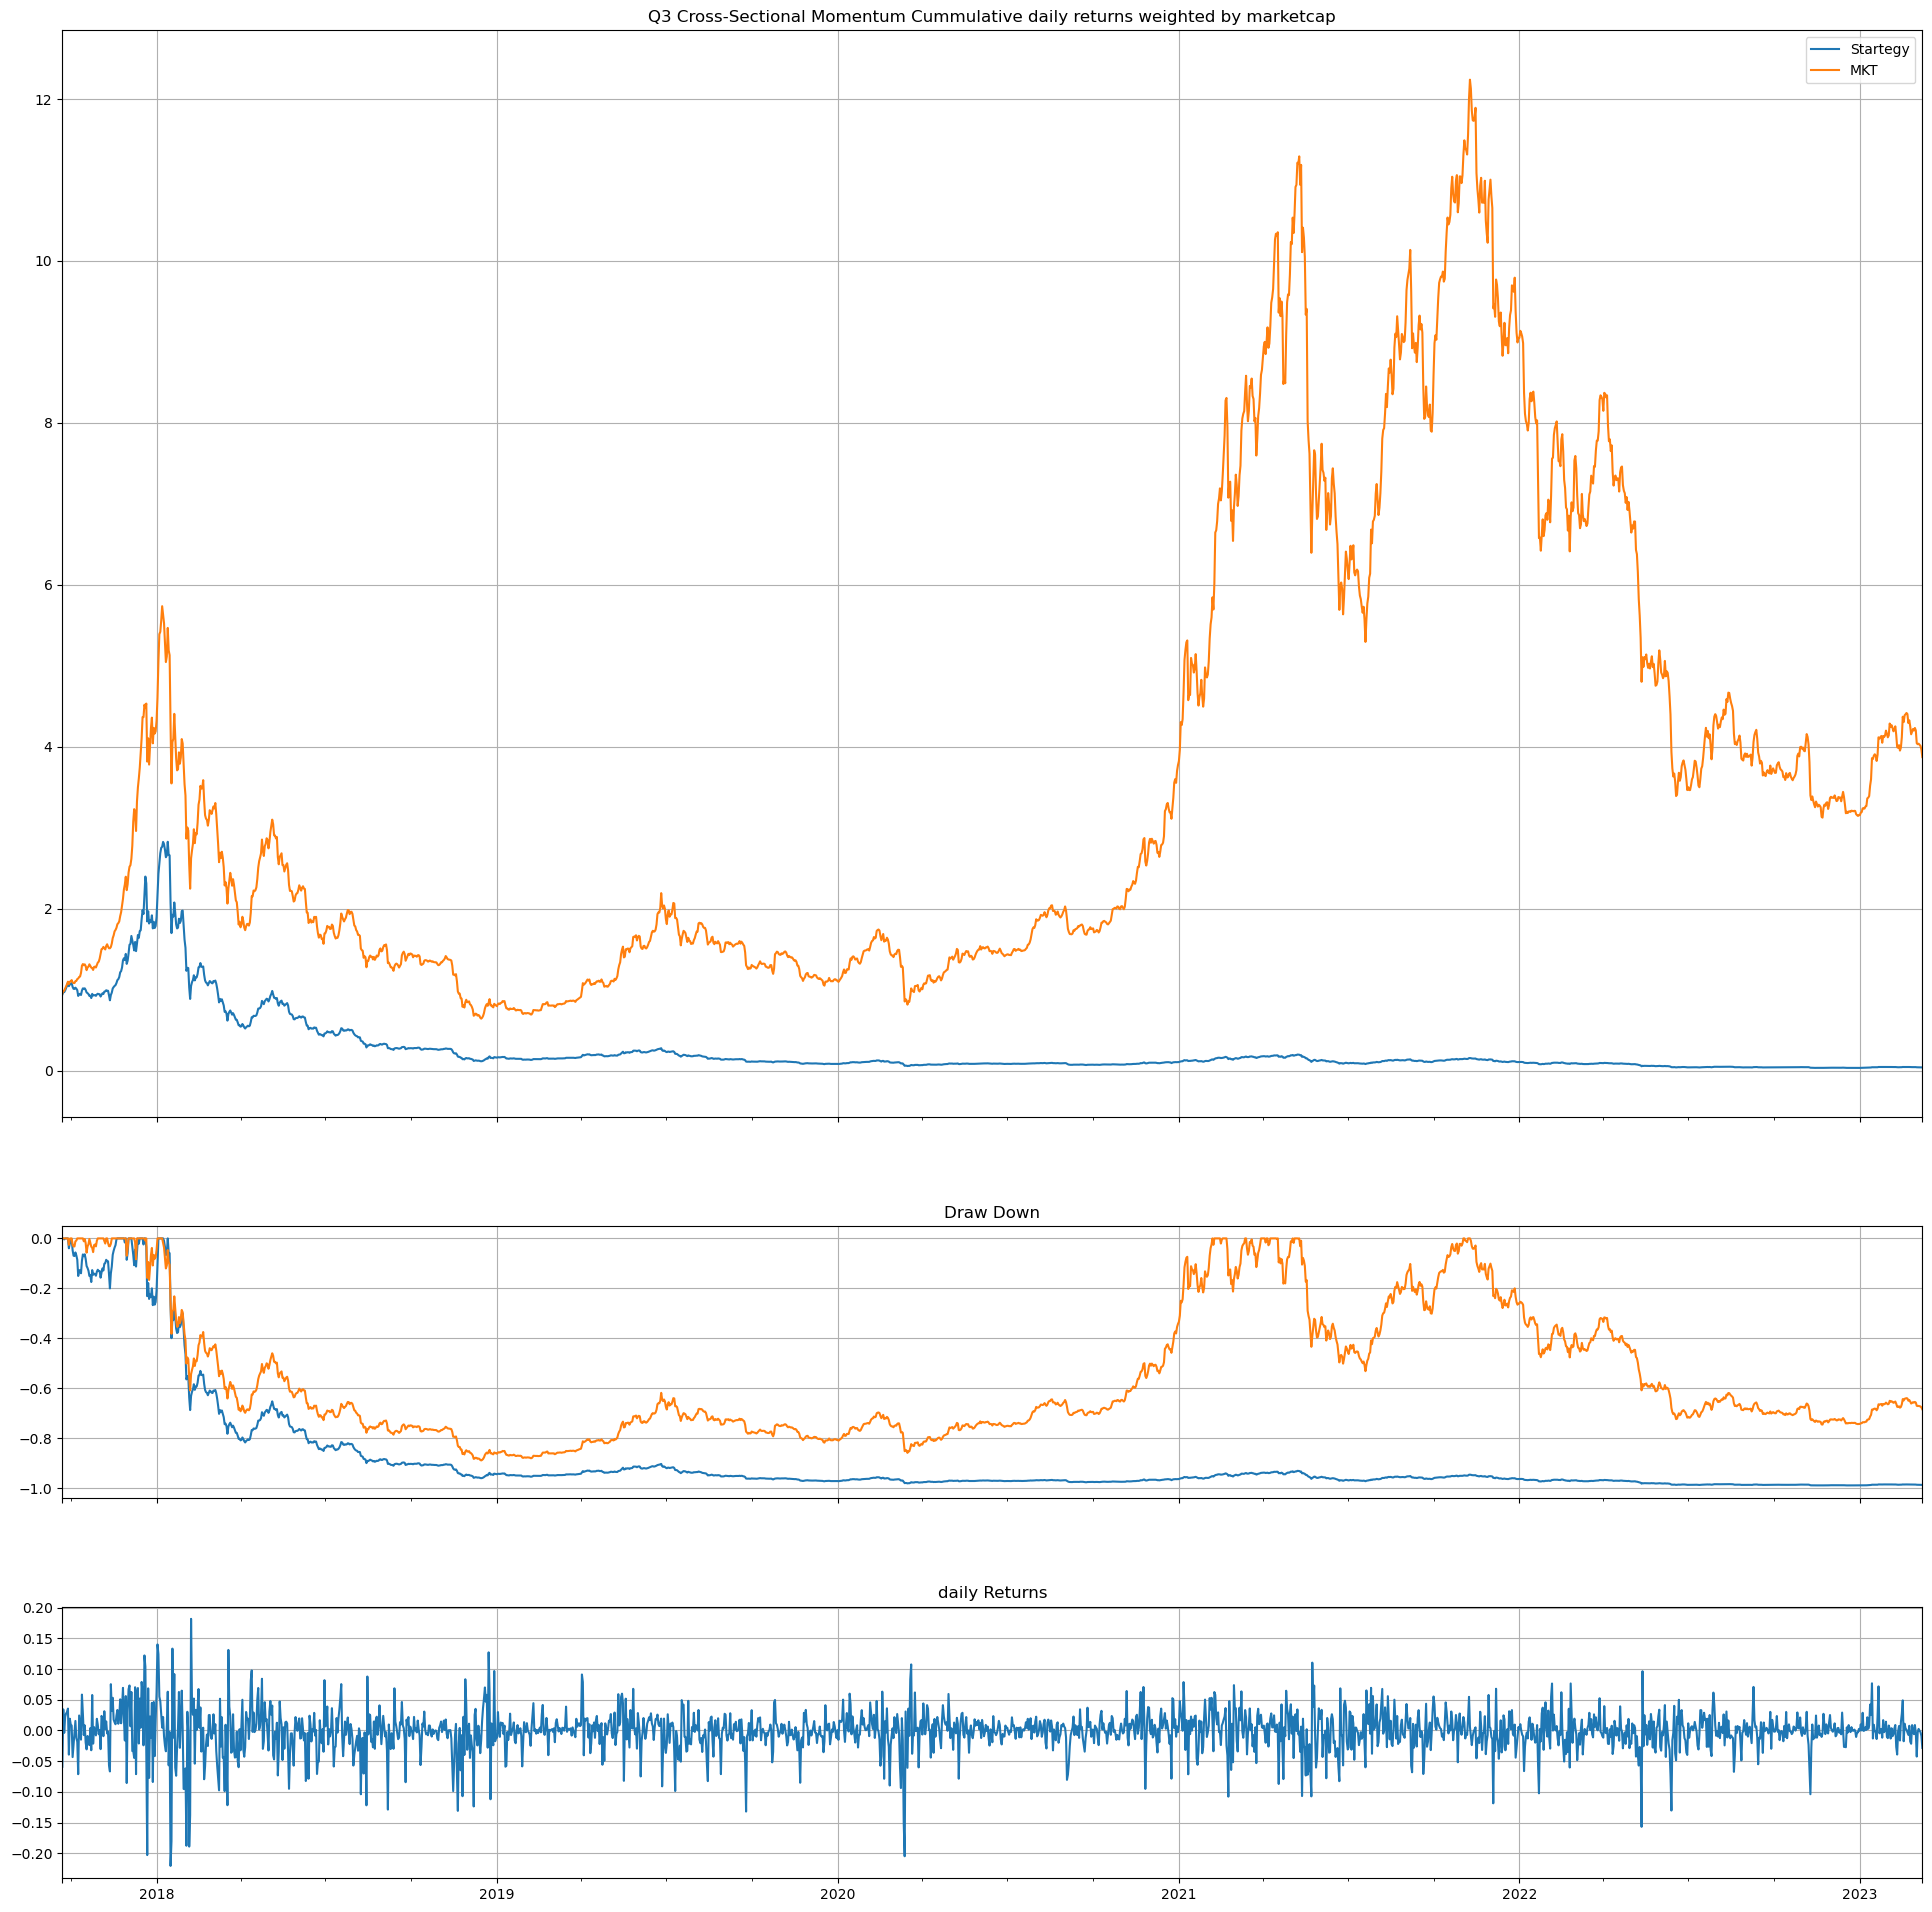

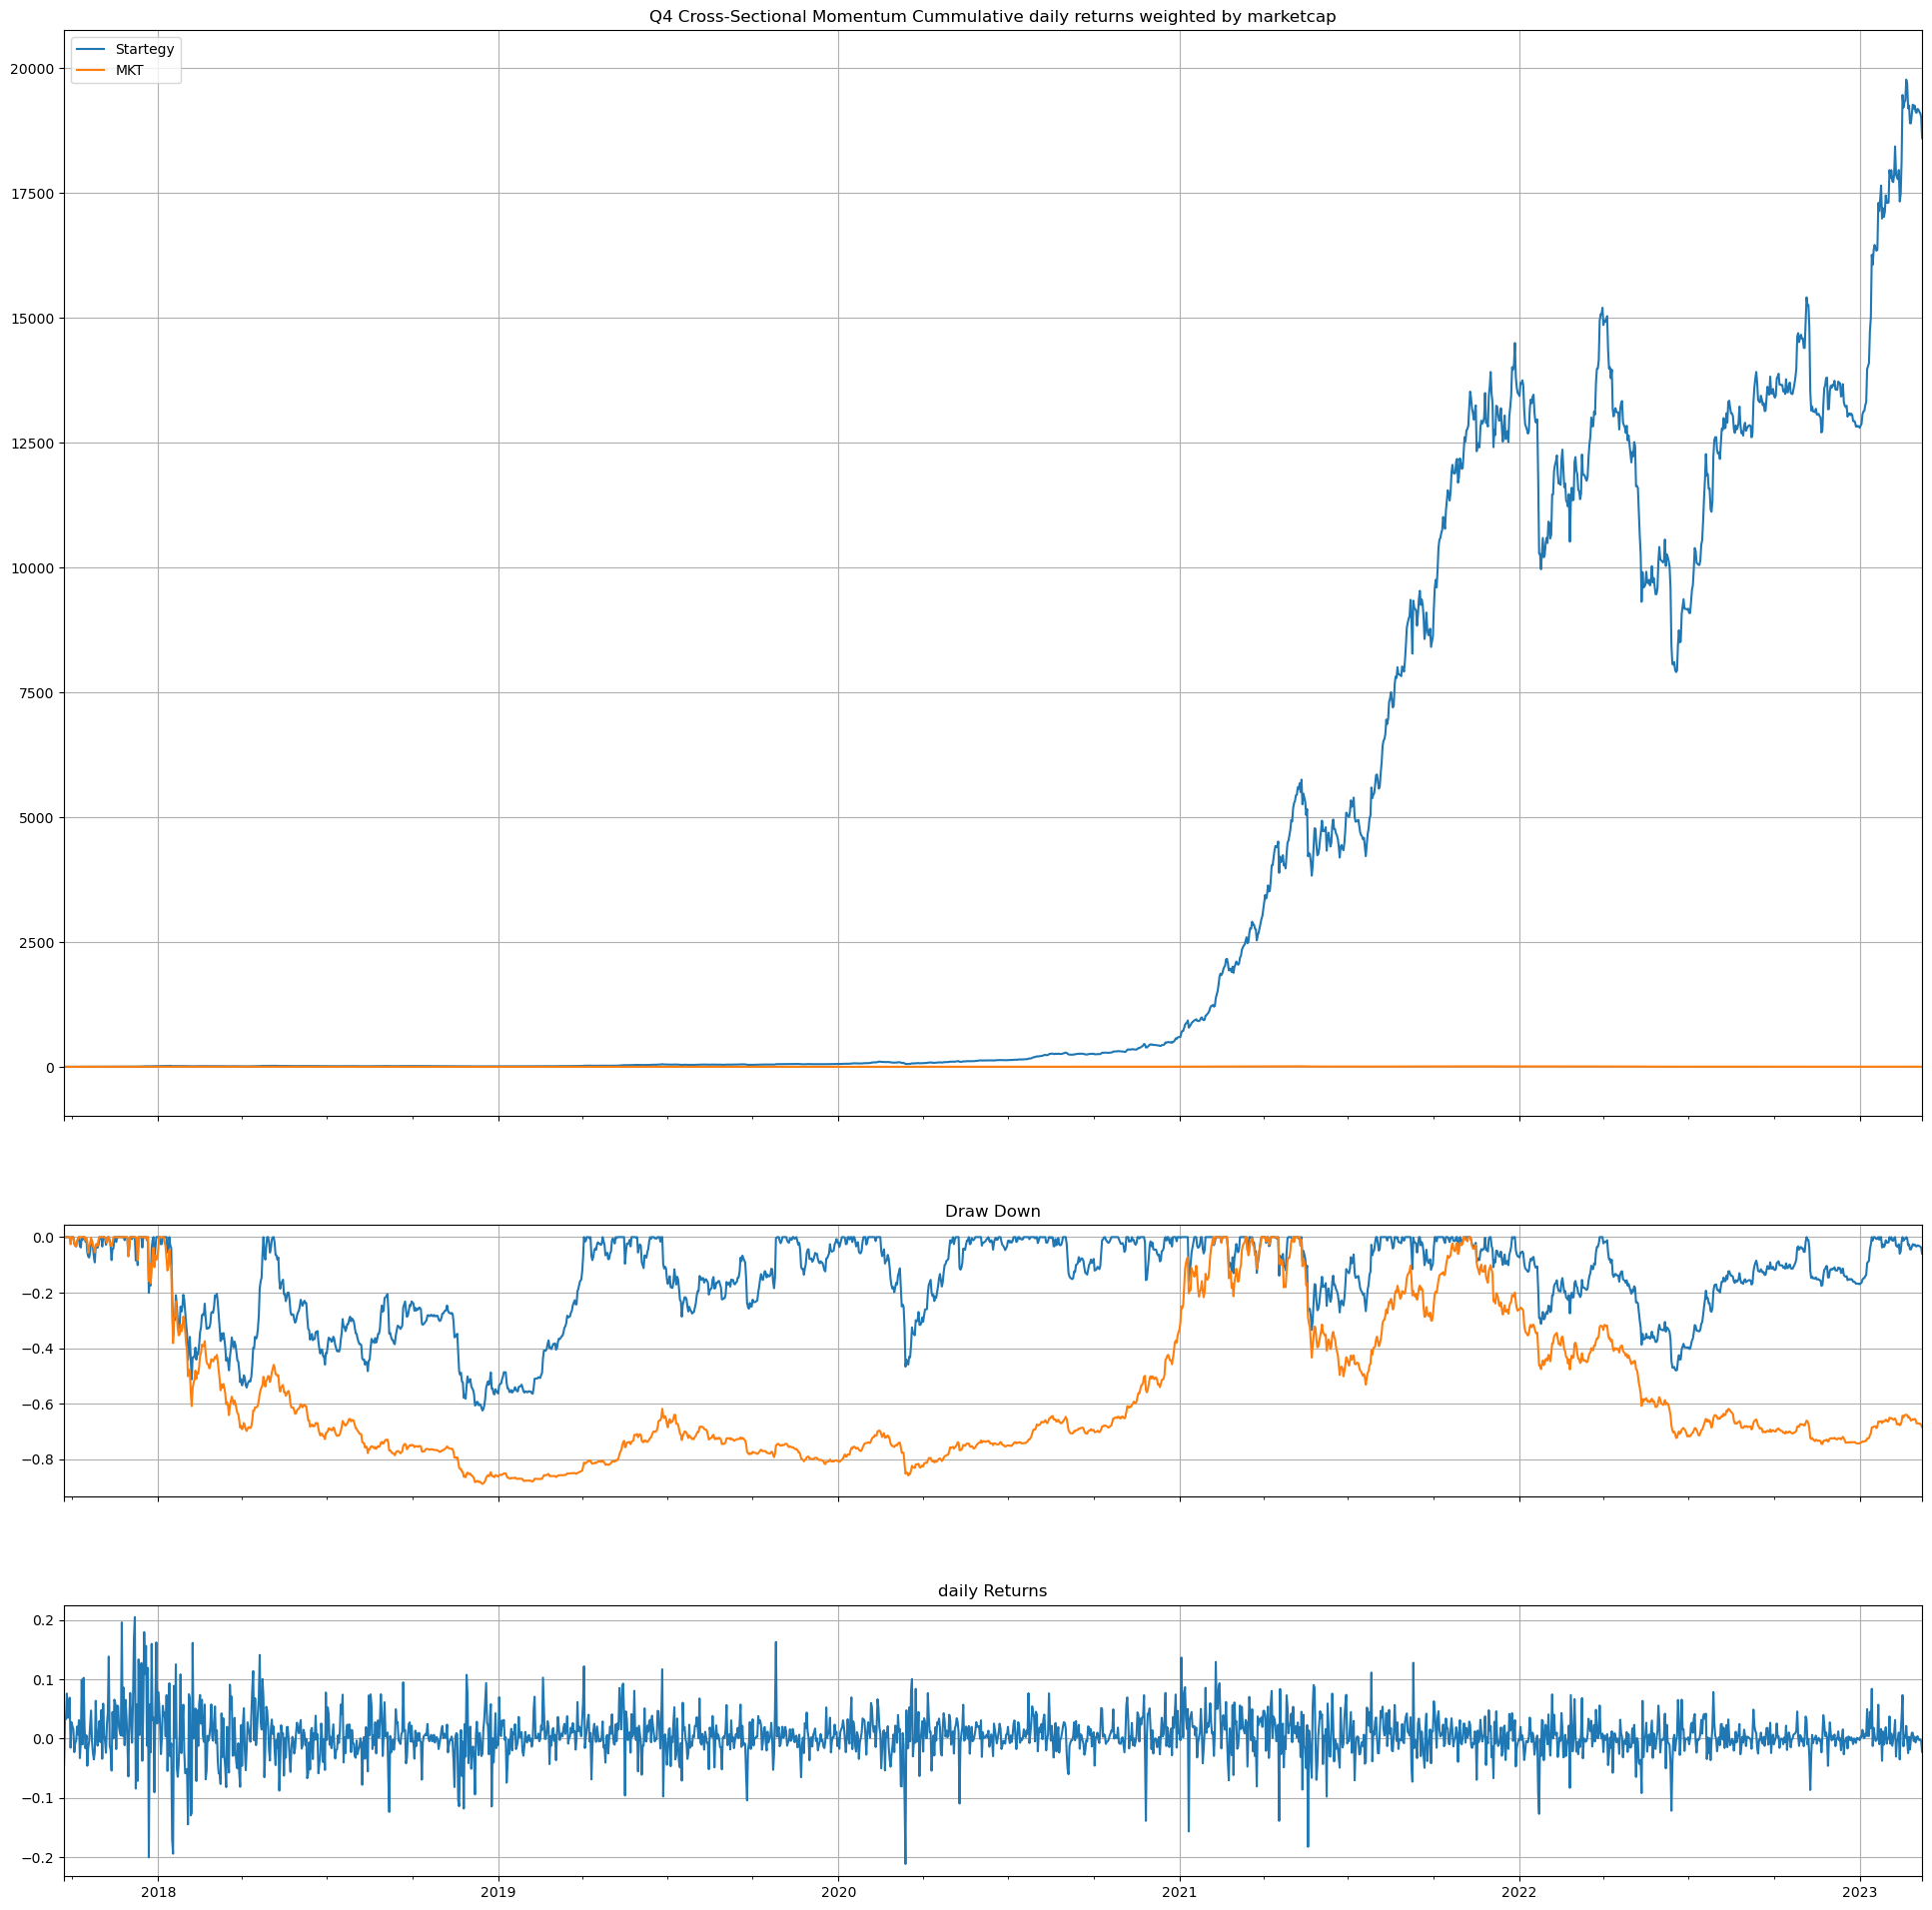

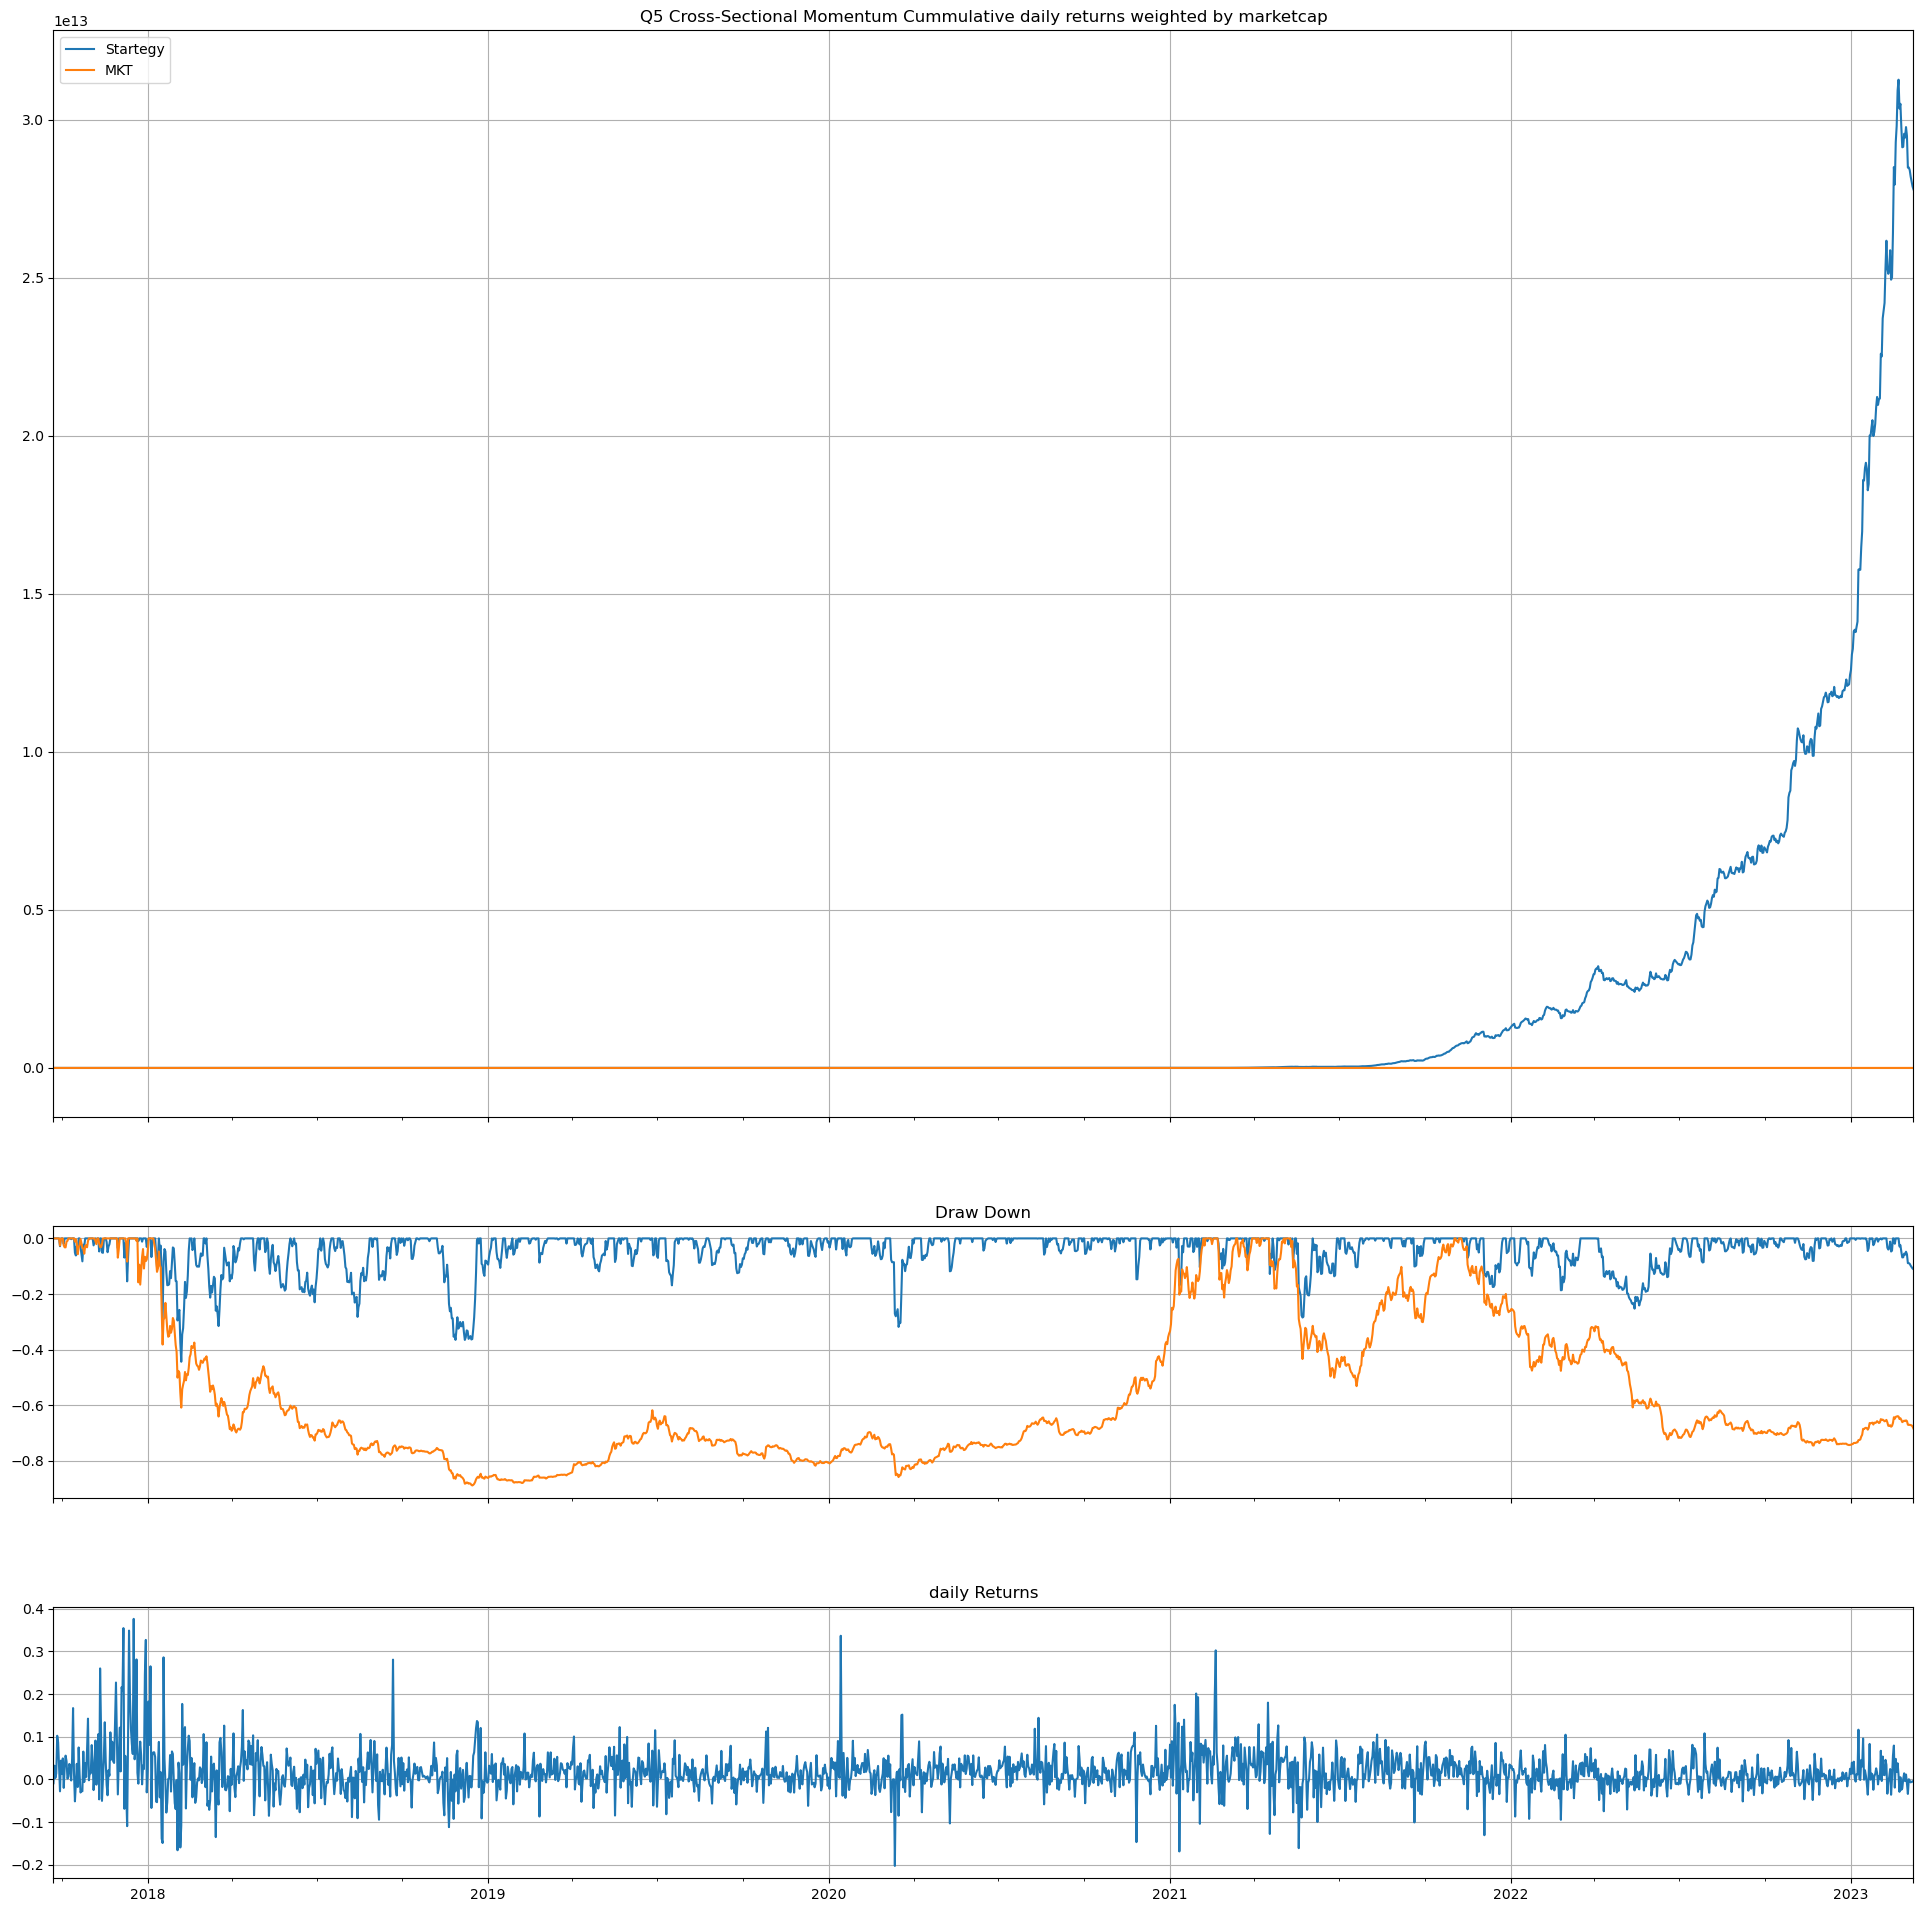

In [111]:
daily.draw_return_result(q5_daily, with_mkt=True)

In [ ]:
daily.run_alpha_regression(q5_daily)

In [109]:
daily.print_statistics(q5_daily, with_mkt=True)

,Q1,Q2,Q3,Q4,Q5,MKT
CAGR,-0.995344,-0.908813,-0.395339,4.606634,326.618078,0.292954
Mean,-0.013605,-0.005745,-0.000737,0.005444,0.017198,0.001281
STD,0.043994,0.038405,0.034903,0.037550,0.048994,0.032963
Shape,-5.908104,-2.857939,-0.403417,2.769833,6.706263,0.742554


In [ ]:
# 리턴이 통계적으로 다름을 보이기

# weekly MKT returns의 통계량
print("Coin MKT:", mkt_sample.mean(), mkt_sample.std())

# 5분위로 나눈 통계량
print("G1:", rtn1.mean().round(4), rtn1.std(ddof=1))
print("G2:", rtn2.mean().round(4), rtn2.std(ddof=1))
print("G3:", rtn3.mean().round(4), rtn3.std(ddof=1))
print("G4:", rtn4.mean().round(4), rtn4.std(ddof=1))
print("G5:", rtn5.mean().round(4), rtn5.std(ddof=1))

t, p_val = stats.ttest_ind(rtn4, rtn5, equal_var=False)
t, p_val

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample)

print("----------------")
print("Group Return")
calculate_cagr(rtn1)
calculate_cagr(rtn2)
calculate_cagr(rtn3)
calculate_cagr(rtn4)
calculate_cagr(rtn5)

In [ ]:
concat_df = pd.concat([rtn1, rtn2, rtn3, rtn4 , rtn5, mkt_sample], 
                      axis=1)
concat_df.columns = ["One","Two","Three","Four","Five","MKT"]

concat_df.corr()

In [ ]:
# 3개 그룹의 결과를 뽑자
mkt_sample2 = result1.loc[start_date2:].iloc[:-1]
rtn_s_sample = rtn_s.loc[start_date2:]
rtn_m_sample = rtn_m.loc[start_date2:]
rtn_h_sample = rtn_h.loc[start_date2:]

In [ ]:
print("S:", rtn_s_sample.mean().round(4), rtn_s_sample.std(ddof=1))
print("M:", rtn_m_sample.mean().round(4), rtn_m_sample.std(ddof=1))
print("H:", rtn_h_sample.mean().round(4), rtn_h_sample.std(ddof=1))

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample2)

print("----------------")
print("Group Return")
calculate_cagr(rtn_s_sample)
calculate_cagr(rtn_m_sample)
calculate_cagr(rtn_h_sample)

In [ ]:
concat_df2 = pd.concat([rtn_s_sample, rtn_m_sample,
                        rtn_h_sample, mkt_sample2], 
                       axis=1)
concat_df2.columns = ["Low","Middle","High","MKT"]

concat_df2.corr()

In [ ]:
t, p_val = stats.ttest_ind(rtn_m_sample, 
                           rtn_h_sample)
t,p_val

In [ ]:
model = OLS(rtn_h_sample, 
            add_constant(mkt_sample2))
                            
model.fit().summary2()

In [ ]:
(result1.loc[start_date2:].iloc[:-1] +1)\
    .cumprod().plot(figsize=(24,12), label="Strategy")
(mkt_sample +1).cumprod().plot(figsize=(24,12),
                               label="MKT")
plt.legend();

* Long-Short 전략

코인 롱숏은 숏 한방을 얻어 맞고 죽는듯.....